In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import torchio as tio
import nibabel as nib
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

DIAMS_PATH = '/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/val/diams'
IMAGES_PATH = '/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/val/images'
MASKS_PATH = '/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/val/masks'
SPRS_PATH = '/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/val/sprs'


In [50]:
diams_files = os.listdir(DIAMS_PATH)
images_files = os.listdir(IMAGES_PATH)
masks_files = os.listdir(MASKS_PATH)
sprs_files = os.listdir(SPRS_PATH)

def load_npy(dirpath, idx):
    filepaths:list[str] = os.listdir(dirpath)
    filepaths.sort()
    filepath:str = filepaths[idx]
    return np.load(os.path.join(dirpath, filepath))

image:np.ndarray = load_npy(IMAGES_PATH, 0)
mask:np.ndarray = load_npy(MASKS_PATH, 0)

pos_coords:list[tuple[int, int, int]] = list(zip(*np.where(mask == 1)))
print(len(pos_coords))

335


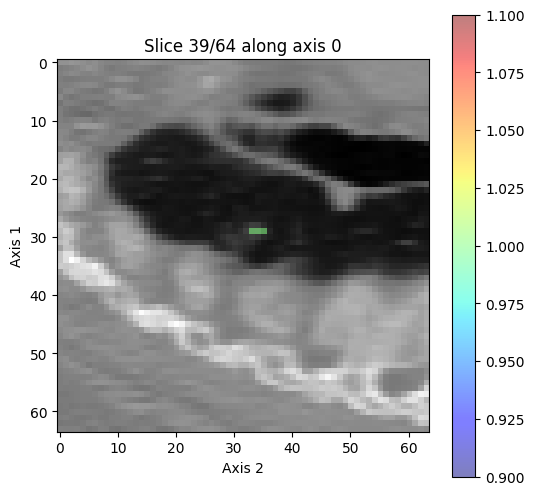

In [62]:
# Display the middle slice along the first axis (e.g., axial view)
# You can change the axis index (0, 1, or 2) to view slices along different planes
axis_to_slice = 0
middle_slice_idx = 39

image_slice = image.take(indices=middle_slice_idx, axis=axis_to_slice)
mask_slice = mask.take(indices=middle_slice_idx, axis=axis_to_slice)
masked_mask = ma.masked_where(mask_slice == 0, mask_slice)

plt.figure(figsize=(6, 6)) # Optional: Adjust figure size
plt.imshow(image_slice, cmap='gray')
plt.imshow(masked_mask, cmap='jet', alpha=0.5)

plt.title(f'Slice {middle_slice_idx}/{image.shape[axis_to_slice]} along axis {axis_to_slice}')
plt.xlabel(f'Axis {(axis_to_slice + 2) % 3}') # Adjust axis labels based on slice axis
plt.ylabel(f'Axis {(axis_to_slice + 1) % 3}')
plt.colorbar()
plt.show()

In [3]:
from dataset import AllDataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

IMAGE_DIR = '/radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/train/images_2D_0axis'
MASK_DIR = '/radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/train/masks_2D_0axis'

dataset = AllDataset(IMAGE_DIR, MASK_DIR, augment=True, normalize=True)
print(len(dataset))

11933


(64, 64) (64, 64)


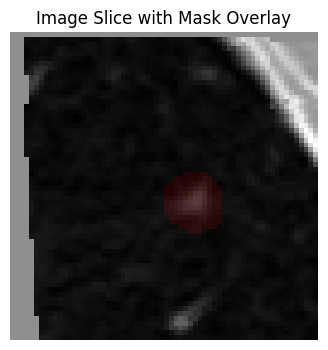

In [6]:
image_2D, mask_2D = dataset[8]

image_2D = image_2D.squeeze(0).numpy()
mask_2D = mask_2D.squeeze(0).numpy()

print(image_2D.shape, mask_2D.shape)
# --- Create Overlay Plot ---

# Create a masked version of the mask where zeros are masked (transparent)
# This assumes mask values > 0 should be overlaid. Adjust condition if needed (e.g., mask_2D == 1)
masked_mask = np.ma.masked_where(mask_2D == 0, mask_2D)

plt.figure(figsize=(4, 4)) # Adjust size as needed

# 1. Plot the base grayscale image
plt.imshow(image_2D, cmap='gray')

# 2. Plot the mask overlay on top
# Define colors: 0 -> transparent, 1 -> semi-transparent red (RGBA format)
colors = [(0, 0, 0, 0), (1, 0, 0, 0.5)] # (R, G, B, Alpha)
# Define the values in your mask that correspond to these colors
nodes = [0.0, 1.0]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_mask", list(zip(nodes, colors)))
plt.imshow(mask_2D, cmap=custom_cmap, vmin=0, vmax=2)

plt.title(f"Image Slice with Mask Overlay")
plt.axis('off') # Hide axes ticks
plt.show()

In [5]:
from dataset import AllDataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os

IMAGE_DIR_3D = '/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/LUNA16/data/val/images/'
MASK_DIR_3D = '/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/LUNA16/data/val/masks/'
IMAGE_DIR_2D = '/radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/images_2D_0axis/'
MASK_DIR_2D = '/radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/masks_2D_0axis/'

images_list = sorted([f for f in os.listdir(IMAGE_DIR_3D) if os.path.isfile(os.path.join(IMAGE_DIR_3D, f))])
masks_list = sorted([f for f in os.listdir(MASK_DIR_3D) if os.path.isfile(os.path.join(MASK_DIR_3D, f))])

for image_path, mask_path in zip(images_list, masks_list):
    if image_path.strip('images_') != mask_path.strip('masks_'):
        raise ValueError(f"Filename mismatch detected after sorting (based on name after first '_'): Image '{image_path}' vs Mask '{mask_path}'")
    
    image = np.load(os.path.join(IMAGE_DIR_3D, image_path)) # type: np.ndarray
    mask = np.load(os.path.join(MASK_DIR_3D, mask_path)) # type: np.ndarray

    if image.shape != mask.shape or image.shape != (64, 64, 64):
        raise ValueError(f"Image and mask shape mismatch: {image.shape} != {mask.shape}")
    
    if np.all(mask == 0):
        raise ValueError(f"Mask is all zeros: {mask_path}")
    
    for i in range(image.shape[0]):
        image_slice = image[i, :, :]
        mask_slice = mask[i, :, :]

        if np.all(mask_slice == 0):
            continue
        
        if not os.path.exists(IMAGE_DIR_2D):
            os.makedirs(IMAGE_DIR_2D)
        if not os.path.exists(MASK_DIR_2D):
            os.makedirs(MASK_DIR_2D)

        image_slice_path = os.path.join(IMAGE_DIR_2D, f"{image_path.strip('.npy')}_slice_{i}.npy")
        mask_slice_path = os.path.join(MASK_DIR_2D, f"{mask_path.strip('.npy')}_slice_{i}.npy")
        print(image_slice_path, mask_slice_path)
        np.save(image_slice_path, image_slice)
        np.save(mask_slice_path, mask_slice)


/radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/images_2D_0axis/images_0068_0931_slice_29.npy /radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/masks_2D_0axis/masks_0068_0931_slice_29.npy
/radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/images_2D_0axis/images_0068_0931_slice_30.npy /radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/masks_2D_0axis/masks_0068_0931_slice_30.npy
/radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/images_2D_0axis/images_0068_0931_slice_31.npy /radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/masks_2D_0axis/masks_0068_0931_slice_31.npy
/radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/images_2D_0axis/images_0068_0931_slice_32.npy /radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/masks_2D_0axis/masks_0068_0931_slice_32.npy
/radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/images_2D_0axis/images_0068_0931_slice_33.npy /radraid2/dongwoolee/VNet_LungNoduleSeg/data/LUNA16/val/masks_2D_0axis/masks_0068_0931_sli